In [153]:
import numpy as np 
import scipy as sc 
import matplotlib.pyplot as plt

In [154]:
## Generate white sequence
seed = 2024
sequence_length = int(1e4)
length_signal_filter=np.min(np.array([sequence_length//2,128]))

fft_length = sequence_length  # int(1e5)

number_realizations = 200

rng = np.random.default_rng(seed)
signal_filter = np.ones(shape=(length_signal_filter))  ## low pass filter


white_noise_sequences = np.zeros(shape=(number_realizations, sequence_length))
acf_noises = np.zeros(shape=(number_realizations, sequence_length))
signals = np.zeros(shape=(number_realizations, sequence_length))
acf_signals = np.zeros(shape=(number_realizations, sequence_length))

for i in range(number_realizations):
    white_noise_sequence = rng.standard_normal(sequence_length)
    white_noise_sequences[i, :] = white_noise_sequence
    acf_noises[i, :] = np.correlate(white_noise_sequence, white_noise_sequence, "same")
    ## generate realization of a weak stationar process
    signals[i, :] = np.convolve(white_noise_sequence, signal_filter,"same")
    acf_signals[i,:] = np.correlate(signals[i, :], signals[i, :], "same")


# mean in probability sense

acf_signal_mean=np.mean(acf_signals,axis=0)
acf_noises_mean=np.mean(acf_noises,axis=0)


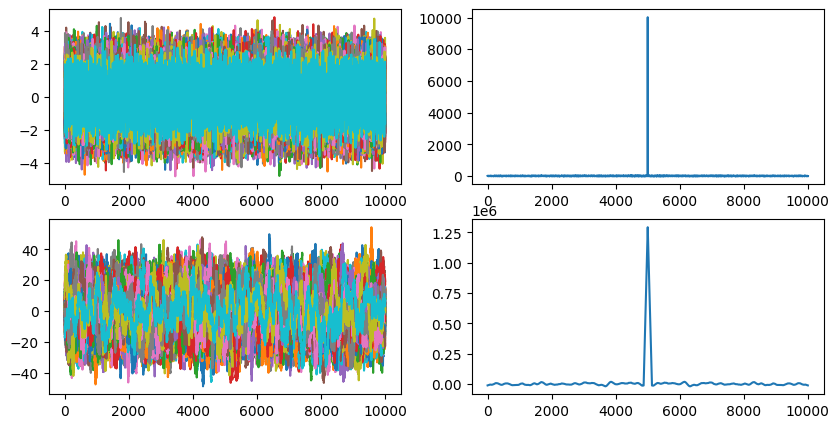

In [155]:
# Plot of all realizations

fig, ax = plt.subplots(2, 2, figsize=(10, 5))
ax[0 ][0].plot(white_noise_sequences.T)
ax[0][1].plot(acf_noises_mean)
ax[1][0].plot(signals.T)
ax[1][1].plot(acf_signal_mean)


In [156]:


fft_acf_noises = np.fft.fft(np.fft.ifftshift(acf_noises_mean), n=fft_length) #ifftshift to move akf peak to zero

fft_acf_signals = np.fft.fft(np.fft.ifftshift(acf_signal_mean), n=fft_length) #ifftshift to move akf peak to zero

fft_filter=np.fft.fft(np.fft.ifftshift(signal_filter), n=fft_length)

(-1.0, 1.0)

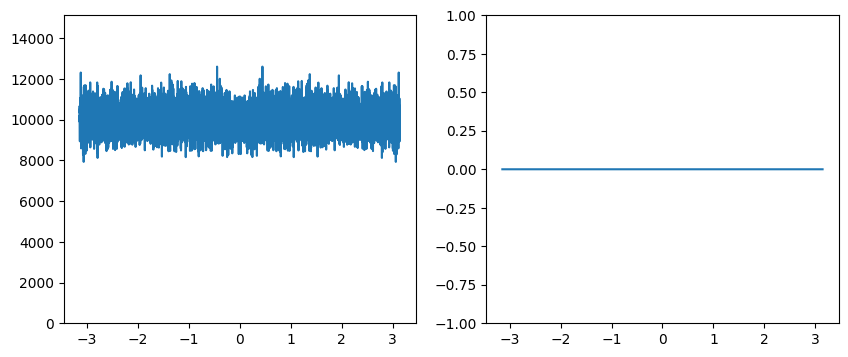

In [157]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(
    (2 * np.arange(fft_length) / (fft_length) - 1) * np.pi,
    np.abs(fft_acf_noises),
)

ax[0].set_ylim(0,1.2*np.max( np.abs(fft_acf_noises)))


ax[1].plot(
    (2 * np.arange(fft_length) / (fft_length) - 1) * np.pi, np.angle(fft_acf_noises)
)
ax[1].set_ylim(-1,1)




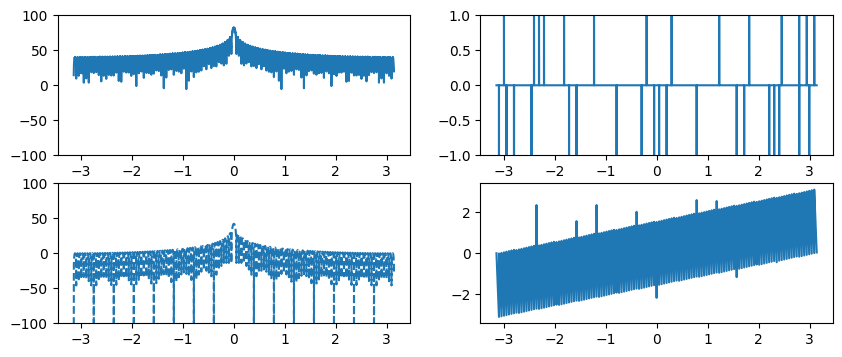

In [158]:
fig, ax = plt.subplots(2, 2, figsize=(10, 4))
ax[0][0].plot(
    (2 * np.arange(fft_length) / (fft_length) - 1) * np.pi,
    10
    * np.log10(
        np.fft.fftshift(np.abs(fft_acf_signals))
    ),
)
ax[0][0].set_ylim(-100, 100)

ax[1][0].plot(
    (2 * np.arange(fft_length) / (fft_length) - 1) * np.pi,
  20
    * np.log10(np.fft.fftshift(np.abs(fft_filter)+1e-8) ),
    linestyle="dashed",
)

ax[1][0].set_ylim(-100, 100)


ax[0][1].plot(
    (2 * np.arange(fft_length) / (fft_length) - 1) * np.pi, np.angle(fft_acf_signals)
)
ax[0][1].set_ylim(-1, 1)

ax[1][1].plot(
    (2 * np.arange(fft_length) / (fft_length) - 1) * np.pi, np.angle(fft_filter)
)
# ax[1][1].set_ylim(-np.pi, np.pi)

In [159]:


noise_std_dev=1000

# get some realizations of white noise
additive_noise_sequences=noise_std_dev*rng.standard_normal(size=(number_realizations,sequence_length))


y=additive_noise_sequences+signals

# Goal, find filter with length N that yields the optimal filtering result

N=8

n=256 #must be larger than N
# Define desired filter taps
K=1
wk=np.zeros(N)
wk[K]=1
# wk = np.array([0,])
# hk = np.array([1])

# now use approach from lecture
Czz=(additive_noise_sequences[:,n:n+N].T@additive_noise_sequences[:,n:n+N])/number_realizations
R_ss_K=(signals[:,n+K:n+N+K].T@signals[:,n:n+N])/number_realizations
R_ss_0=(signals[:,n:n+N].T@signals[:,n:n+N])/number_realizations

#Formular from lecture
g=wk.T@R_ss_K@np.linalg.inv(R_ss_0+Czz)

g[g<1e-6]=0

print(wk)
print(g)



[0. 1. 0. 0. 0. 0. 0. 0.]
[1.03378732e-04 9.91295125e-05 1.31987277e-04 1.76021240e-04
 1.36074089e-04 1.36009518e-04 1.32834519e-04 7.20291065e-05]


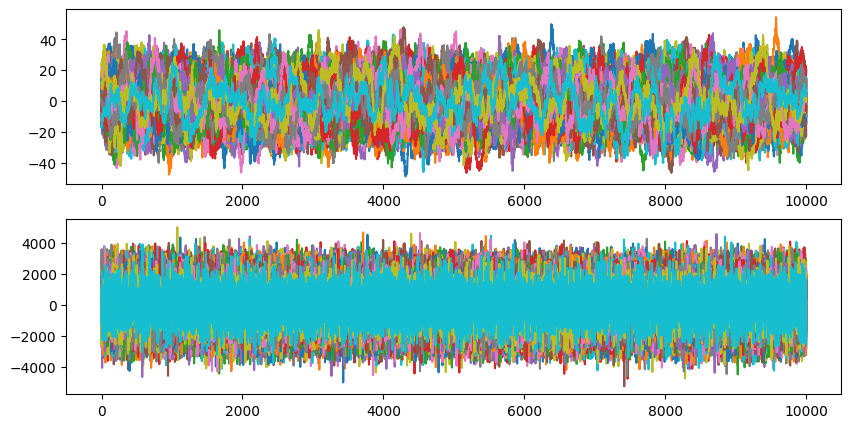

In [160]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
ax[0].plot(signals.T)
ax[1].plot(y.T)
plt.show()

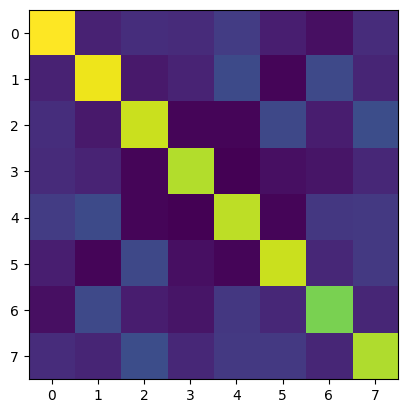

In [161]:

plt.imshow(Czz, interpolation='nearest')
plt.show()

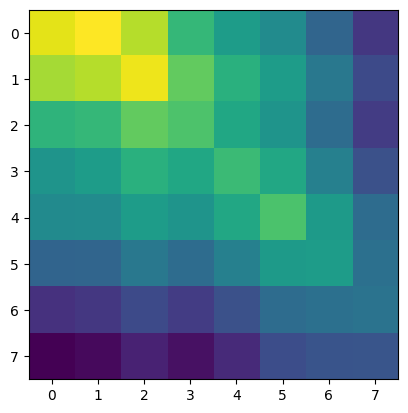

In [162]:
plt.imshow(R_ss_K, interpolation='nearest')
plt.show()

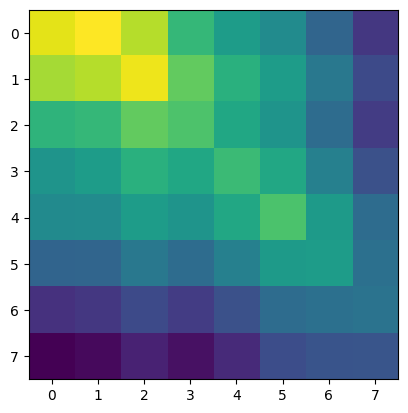

In [163]:
plt.imshow(R_ss_K, interpolation='nearest')
plt.show()

In [164]:
x_hat=np.apply_along_axis(lambda m:np.convolve(m, g, mode='same'), axis=1, arr=y)[:,K:]

x=np.apply_along_axis(lambda m:np.convolve(m, wk, mode='same'), axis=1, arr=signals)[:,0:-K]




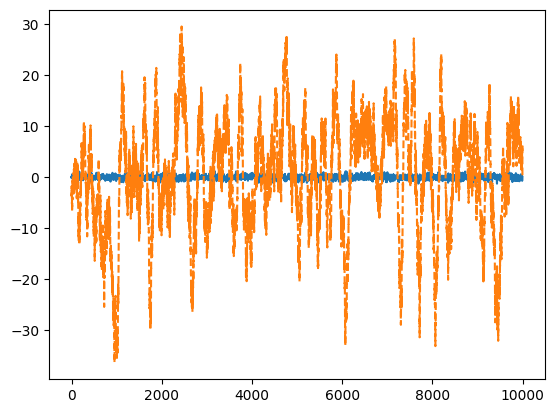

In [165]:
choose_realization=40

plt.plot(x_hat[choose_realization,:])
plt.plot(x[choose_realization,:],linestyle='dashed')
plt.show()

In [166]:
## now the approach from the exercise
# G(f)=S_UY(f)/S_YY(f)
acf_signals_y=np.zeros(shape=y.shape)
for i,y_sig in enumerate(y):
    acf_signals_y[i,:]=np.correlate(y_sig,y_sig,'same')

correlations_x_y=np.zeros(shape=y.shape)
for i,y_sig in enumerate(y):
    correlations_x_y[i,:]=np.correlate(x[i,:],y_sig,'same')#####

acf_signal_y_mean=np.mean(acf_signals_y,axis=0)
ccf_noises_mean=np.mean(correlations_x_y,axis=0)

In [167]:
S_yy = np.fft.fft(np.fft.ifftshift(acf_signal_y_mean),n=10*N)
S_xy = np.fft.fft(np.fft.ifftshift(ccf_noises_mean),n=10*N)

G_ex = S_xy / S_yy
G=np.abs(np.fft.fft(np.fft.ifftshift(g)))
#
g_exercise=np.fft.ifft(G_ex,N)

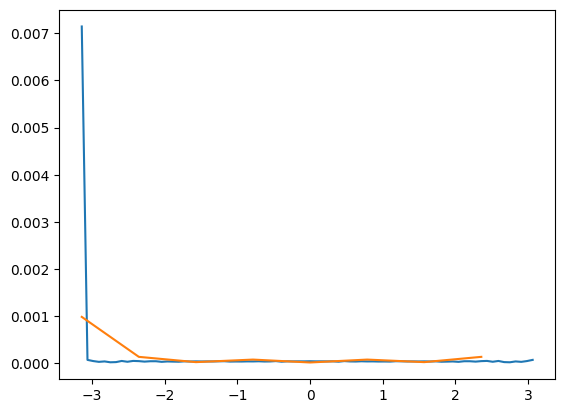

In [168]:
plt.plot((2 * np.arange(len(G_ex)) / (len(G_ex)) - 1) * np.pi,G_ex)
plt.plot((2 * np.arange(len(G)) / (len(G)) - 1) * np.pi,G)
plt.show()


In [169]:
x_hat_ex=np.apply_along_axis(lambda m:np.convolve(m, g_exercise, mode='same'), axis=1, arr=y)[:,:]

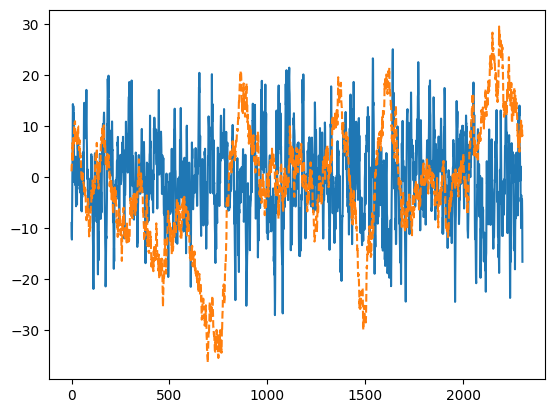

In [170]:
plt.plot(x_hat_ex[choose_realization,:][n:10*n]/np.max(x_hat_ex[choose_realization,:])*np.max(x[choose_realization,:]))
plt.plot(x[choose_realization,:][n+K:10*n+K],linestyle='dashed')
plt.show()